In [1557]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report, confusion_matrix, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import plot_tree

In [1558]:
def data_results(testing_classes, testing_inputs, alg_class):
    cm_display = ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(testing_classes, alg_class.predict(testing_inputs))
    )

    cm_display.plot()
    plt.xticks([0, 1], ["No", "Yes"])
    plt.yticks([0, 1], ["No", "Yes"])
    plt.xlabel('Predicted Entry')
    plt.ylabel('Actual Entry')
    plt.show()

    print(classification_report(testing_classes, alg_class.predict(testing_inputs)))

rank                   0
PER                    0
Cumulative Win Rate    0
dtype: int64
   year       PER     coachID  Cumulative Win Rate  playoff  playoffNextYear
2     1  3.152351  dunntr01wc             0.281250        0                1
3     2  3.357608  donovan99w             0.482812        1                1
4     3  3.222922  donovan99w             0.516033        1                1
5     4  3.168911  laceytr99w             0.500000        1                0
6     5  3.259226  laceytr99w             0.477941        0                0
7     6  3.050083  laceytr99w             0.516033        0                0
Feature: rank, Importance: 0.169793771043771
Feature: PER, Importance: 0.4841843744666326
Feature: Cumulative Win Rate, Importance: 0.3460218544895964


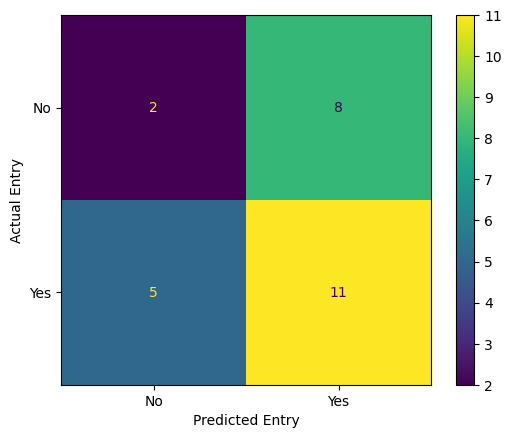

              precision    recall  f1-score   support

           0       0.29      0.20      0.24        10
           1       0.58      0.69      0.63        16

    accuracy                           0.50        26
   macro avg       0.43      0.44      0.43        26
weighted avg       0.47      0.50      0.48        26



In [ ]:
df_teams = pd.read_csv('dataset/processed/teams_test.csv')
df_teams = df_teams.sort_values(by=['franchID', 'year'])
df_teams['playoffNextYear'] = df_teams['playoff'].shift(-1)
df_teams.loc[df_teams['franchID'] != df_teams['franchID'].shift(-1), 'playoffNextYear'] = None
df_teams.dropna(subset=['playoffNextYear'], inplace=True)
#df_teams["confW"] = df_teams["confW"].fillna(0)
#df_teams = df_teams.fillna(-1)
label_encoder = LabelEncoder()
df_teams['playoff'] = label_encoder.fit_transform(df_teams['playoff'])
df_teams['playoffNextYear'] = label_encoder.fit_transform(df_teams['playoffNextYear'])
features = ['PER', 'Cumulative Win Rate'] # attend?

df_teams_train = df_teams[df_teams['year'] <= 7]
df_teams_test = df_teams[df_teams['year'].isin([8,9])]
# df_teams_train = df_teams[df_teams['year'] <= 5]
# df_teams_test = df_teams[df_teams['year'].isin([6])]

training_inputs = df_teams_train[features]
training_classes = df_teams_train['playoffNextYear']
testing_inputs = df_teams_test[features]
testing_classes = df_teams_test['playoffNextYear']
print(training_inputs.isna().sum())
print(df_teams_train[df_teams_train['tmID'] == "CHA"][['year', 'PER', 'coachID', 'Cumulative Win Rate', 'playoff', 'playoffNextYear']])

dt_class = DecisionTreeClassifier(random_state=42)
dt_class.fit(training_inputs, training_classes)
# print(training_inputs.isna().sum())
dt_class.predict(testing_inputs)

dt_class.score(testing_inputs, testing_classes)

accuracy_score(testing_classes, dt_class.predict(testing_inputs))

importance = dt_class.feature_importances_
for feature, imp in zip(features, importance):
    print(f"Feature: {feature}, Importance: {imp}")

'''f = open("results.txt", "a")
f.write("Year 9 Accuracy = " + str(accuracy_score(testing_classes, dt_class.predict(testing_inputs))) + "\n")
f.close()'''

data_results(testing_classes, testing_inputs, dt_class)

# plot_tree(dt_class, feature_names=features, filled=True)

Feature: rank, Importance: 0.19656114309837136
Feature: PER, Importance: 0.4721111699386383
Feature: Cumulative Win Rate, Importance: 0.33132768696299053


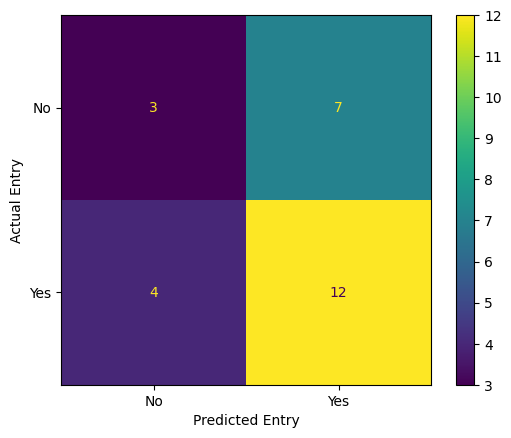

              precision    recall  f1-score   support

           0       0.43      0.30      0.35        10
           1       0.63      0.75      0.69        16

    accuracy                           0.58        26
   macro avg       0.53      0.53      0.52        26
weighted avg       0.55      0.58      0.56        26



In [1560]:
rf_class = RandomForestClassifier(n_estimators=100)
rf_class.fit(training_inputs, training_classes)

# print(rf_class.predict_proba(training_inputs))

importance = rf_class.feature_importances_
for feature, imp in zip(features, importance):
    print(f"Feature: {feature}, Importance: {imp}")

rf_class.score(testing_inputs, testing_classes)

accuracy_score(testing_classes, rf_class.predict(testing_inputs))

data_results(testing_classes, testing_inputs, rf_class)

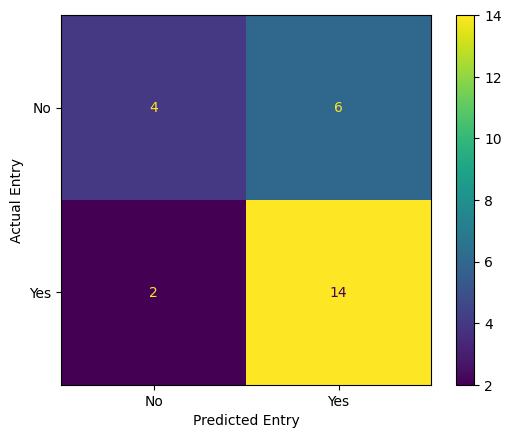

              precision    recall  f1-score   support

           0       0.67      0.40      0.50        10
           1       0.70      0.88      0.78        16

    accuracy                           0.69        26
   macro avg       0.68      0.64      0.64        26
weighted avg       0.69      0.69      0.67        26



In [1561]:
rdg_class = RidgeClassifier()
rdg_class.fit(training_inputs, training_classes)

# print(rdg_class.predict_proba(training_inputs))

rdg_class.score(testing_inputs, testing_classes)

accuracy_score(testing_classes, rdg_class.predict(testing_inputs))

data_results(testing_classes, testing_inputs, rdg_class)

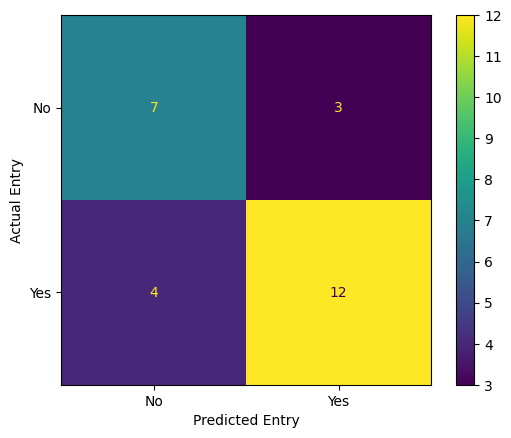

              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.80      0.75      0.77        16

    accuracy                           0.73        26
   macro avg       0.72      0.72      0.72        26
weighted avg       0.74      0.73      0.73        26



In [1562]:
nb_class = GaussianNB()
nb_class.fit(training_inputs, training_classes)

nb_class.score(testing_inputs, testing_classes)

accuracy_score(testing_classes, nb_class.predict(testing_inputs))

data_results(testing_classes, testing_inputs, nb_class)

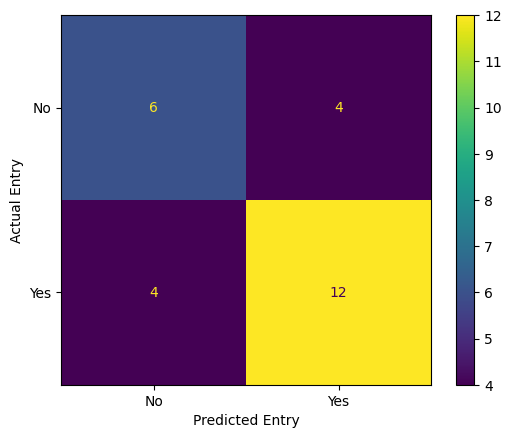

              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.75      0.75      0.75        16

    accuracy                           0.69        26
   macro avg       0.68      0.68      0.68        26
weighted avg       0.69      0.69      0.69        26



In [1563]:
svm_class = SVC(kernel='rbf')
svm_class.fit(training_inputs, training_classes)

svm_class.score(testing_inputs, testing_classes)

accuracy_score(testing_classes, svm_class.predict(testing_inputs))

data_results(testing_classes, testing_inputs, svm_class)

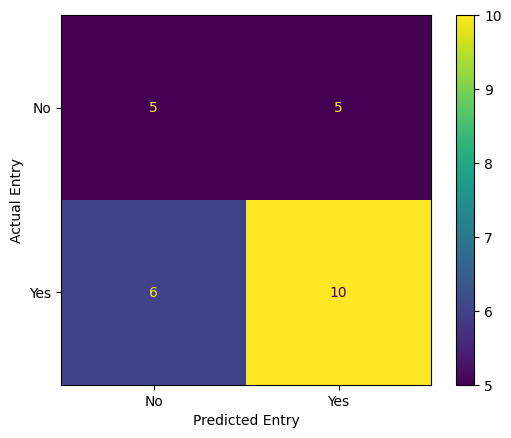

              precision    recall  f1-score   support

           0       0.45      0.50      0.48        10
           1       0.67      0.62      0.65        16

    accuracy                           0.58        26
   macro avg       0.56      0.56      0.56        26
weighted avg       0.59      0.58      0.58        26



In [1564]:
knn_class = KNeighborsClassifier(n_neighbors=5)
knn_class.fit(training_inputs, training_classes)

knn_class.score(testing_inputs, testing_classes)

accuracy_score(testing_classes, knn_class.predict(testing_inputs))

data_results(testing_classes, testing_inputs, knn_class)

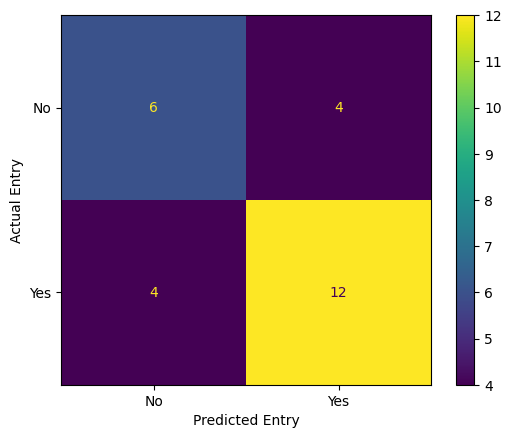

              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.75      0.75      0.75        16

    accuracy                           0.69        26
   macro avg       0.68      0.68      0.68        26
weighted avg       0.69      0.69      0.69        26



In [1565]:
ann_class = MLPClassifier(random_state=42, max_iter=300)
ann_class.fit(training_inputs, training_classes)

ann_class.score(testing_inputs, testing_classes)

accuracy_score(testing_classes, ann_class.predict(testing_inputs))

data_results(testing_classes, testing_inputs, ann_class)

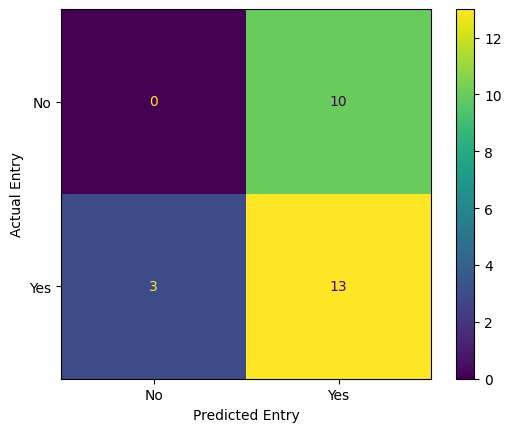

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.57      0.81      0.67        16

    accuracy                           0.50        26
   macro avg       0.28      0.41      0.33        26
weighted avg       0.35      0.50      0.41        26



In [1566]:
ab_class = AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=42)
ab_class.fit(training_inputs, training_classes)

ab_class.score(testing_inputs, testing_classes)

accuracy_score(testing_classes, ab_class.predict(testing_inputs))

data_results(testing_classes, testing_inputs, ab_class)

In [1567]:
'''for w in df_teams['confW']:
    print(w)
nan_count = df_teams['confW'].isna().sum()
print(nan_count)'''

#print(df_teams.isna().sum())

#df_teams.head(164)

df_teams.head(30)

,year,tmID,franchID,confID,rank,playoff,firstRound,semis,finals,name,...,homeL,awayW,awayL,confW,confL,min,PER,coachID,Cumulative Win Rate,playoffNextYear
0,9,ATL,ATL,EA,7,0,NaN,NaN,NaN,Atlanta Dream,...,16,3,14,2,18,6825,3.160357,meadoma99w,0.117647,1
2,1,CHA,CHA,EA,8,0,NaN,NaN,NaN,Charlotte Sting,...,11,3,13,5,16,6475,3.152351,dunntr01wc,0.281250,1
3,2,CHA,CHA,EA,4,1,W,W,L,Charlotte Sting,...,5,7,9,15,6,6500,3.357608,donovan99w,0.482812,1
4,3,CHA,CHA,EA,2,1,L,NaN,NaN,Charlotte Sting,...,5,7,9,12,9,6450,3.222922,donovan99w,0.516033,1
5,4,CHA,CHA,EA,2,1,L,NaN,NaN,Charlotte Sting,...,4,5,12,12,12,6850,3.168911,laceytr99w,0.500000,0
6,5,CHA,CHA,EA,5,0,NaN,NaN,NaN,Charlotte Sting,...,7,6,11,8,12,6900,3.259226,laceytr99w,0.477941,0
7,6,CHA,CHA,EA,6,0,NaN,NaN,NaN,Charlotte Sting,...,12,1,16,4,16,6945,3.050083,laceytr99w,0.516033,0
9,7,CHI,CHI,EA,7,0,NaN,NaN,NaN,Chicago Sky,...,14,2,15,4,16,6800,3.116197,cowenda01w,0.516033,0
10,8,CHI,CHI,EA,6,0,NaN,NaN,NaN,Chicago Sky,...,11,8,9,6,14,6972,3.140279,overtbo99w,0.516033,0
11,9,CHI,CHI,EA,5,0,NaN,NaN,NaN,Chicago Sky,...,9,4,13,10,10,6875,3.126865,keyst99wc,0.352941,0
